In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.utils import check_array, _safe_indexing, sparsefuncs_fast, check_X_y, check_random_state
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from numbers import Integral
from sklearn.svm import SVC
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE
import os
# import missingpy as missingpy
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import pickle
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Set folder paths for outputs

In [2]:
os.chdir('..')
REPO_ROOT = Path(os.getcwd())
DATA = Path(REPO_ROOT / 'data')
MODELS = Path(REPO_ROOT / 'model')
REPORTS = Path(REPO_ROOT / 'reports' / 'rain')

In [3]:
os.chdir('..')
PATH_1 = Path(os.getcwd())
os.chdir('..')
Path(os.getcwd())

PosixPath('/Users/armandoassembleia/Desktop/Tese/Outlier')

In [4]:
from Mixed_Distances.distMix import distmix
from scipy.spatial.distance import cdist
from Sampling_Methods.Balance import BalanceDataset
from Sampling_Methods.Sampling_Study.auxSamplingStudy import *

In [5]:
os.chdir(PATH_1)
Path(os.getcwd())

PosixPath('/Users/armandoassembleia/Desktop/Tese/Outlier/Sampling_Methods')

# Read the file

In [6]:
df= pd.read_csv(DATA / 'weatherAUS.csv')

In [7]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

#### As we can see Sunshine, Evaporation, Cloud3pm and Cloud9am have around 50% data, we can ignore these four columns We need to remove RISK_MM because we want to predict 'RainTomorrow' and RISK_MM can leak some info to our model We can remove location and date column too, because we are going to findwhich weather conditions affect chancess of rain

In [8]:
df.drop(columns=['Sunshine','Evaporation','Cloud3pm','Cloud9am','RISK_MM','Date','Location'],axis=1, inplace = True)

#### In order to feed the data to any machine learning method, it's convenient to change strings to numeric values. So, we are going to change 'No' to 0 and 'Yes' to 1

In [9]:
df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.isnull().sum()

MinTemp            586
MaxTemp            277
Rainfall          1402
WindGustDir       9279
WindGustSpeed     9219
WindDir9am        9962
WindDir3pm        3727
WindSpeed9am      1297
WindSpeed3pm      2579
Humidity9am       1723
Humidity3pm       3559
Pressure9am      13963
Pressure3pm      13930
Temp9am            853
Temp3pm           2675
RainToday         1402
RainTomorrow         0
dtype: int64

In [12]:
df.shape

(142142, 17)

In [13]:
df.dropna(inplace=True)

In [14]:
df.shape

(112925, 17)

In [15]:
Counter(df.RainTomorrow)

Counter({0: 87906, 1: 25019})

In [16]:
df.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir', 'WindGustSpeed',
       'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

# Create helper functions

In [17]:
## Split the data to be 5-fold cross-validated
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#randomforest model - hyperparameter tuning using grid search

param_grid = {
'max_depth': [7, 10], 'max_features': [7, 12],
'min_samples_leaf': [3, 5], 'min_samples_split': [3, 5], 'n_estimators': [500]
}# Create a base model
param_grid = {'randomforestclassifier__' + key: param_grid[key] for key in param_grid}

In [18]:
# df_feature= df.drop('RainTomorrow',1)
df_target= df[['RainTomorrow']]
df_target = df_target.rename(columns={'RainTomorrow': 'target'})

In [19]:
encoded_df = MultiColumnLabelEncoder(columns = ['WindGustDir', 'WindDir9am', 'WindDir3pm']).fit_transform(df)


In [20]:
anovap_value = list()
for cols in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    statistic, p = stats.f_oneway(encoded_df[cols], encoded_df['RainTomorrow'])
    anovap_value.append(tuple([cols, p]))
    
print(anovap_value)

[('WindGustDir', 0.0), ('WindDir9am', 0.0), ('WindDir3pm', 0.0)]


In [21]:
from scipy.stats import chi2_contingency
chi2p_value = list()
for cols in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    obs = pd.crosstab(encoded_df[cols], encoded_df['RainTomorrow'])
    g, p, dof, expctd = chi2_contingency(obs)
    chi2p_value.append(tuple([cols, p]))
    
print(chi2p_value)

[('WindGustDir', 1.485853343880933e-292), ('WindDir9am', 0.0), ('WindDir3pm', 1.3203990219430103e-251)]


In [22]:
encoded_df= encoded_df.drop('RainTomorrow',1)

In [23]:
1 - 2000 / encoded_df.shape[0]

0.9822891299535089

In [24]:
np.sum(df_target)/df_target.shape[0]

target    0.221554
dtype: float64

In [25]:
#Sampling: Added by me
encoded_df, aux1, df_target, aux2 = train_test_split(encoded_df, df_target, test_size=0.98, random_state=12)

In [26]:
df_target.shape

(2258, 1)

In [27]:
np.sum(df_target)

target    477
dtype: int64

In [28]:
np.sum(df_target)/df_target.shape[0]

target    0.211249
dtype: float64

In [29]:
1/5

0.2

In [30]:
# Split the raw data into train and test set. Split ratio = 75:25

X_train, X_test, y_train, y_test = train_test_split(encoded_df, df_target, test_size=0.25, random_state=12)

In [31]:
col_list = list(X_train.columns)
X_train.index = pd.RangeIndex(len(X_train.index))
y_train.index = pd.RangeIndex(len(y_train.index))
X_test.index = pd.RangeIndex(len(X_test.index))
y_test.index = pd.RangeIndex(len(y_test.index))

In [32]:
X_train.shape

(1693, 16)

In [33]:
## Apply standard scaler on the features , so that euclidean distance calculation in SMOTE is not biased

columns = [0,1,2,4,7,8,9,10,11,12,13,14,15]
name_columns = X_train.columns[columns]

sc = StandardScaler()
X_train[name_columns] = sc.fit_transform(X_train[name_columns])
X_test[name_columns] = sc.transform(X_test[name_columns])

In [34]:
X_train = pd.DataFrame(X_train, index=range(X_train.shape[0]),
                          columns=col_list)
X_test = pd.DataFrame(X_test, index=range(X_test.shape[0]),
                          columns=col_list)

In [35]:
X_train
nbinsA = calculate_nbins(X_train, [3, 5, 6], "average")
nbinsFD = calculate_nbins(X_train, [0,1,2,4,7,8,9,10,11,12,13,14,15], "FD")
print(nbinsA)
print(nbinsFD)

[16, 16, 16]
[20.889992358104177, 23.187833163750582, 1217.6660853836206, 34.00257469020572, 27.087336913472218, 29.254323866549996, 22.23245268205758, 20.85724942337361, 36.023114573916665, 32.577037194602546, 23.234239325555826, 23.650631042575434, inf]
16
27


In [36]:
## Apply the random-forest classifier along with the NEW SMOTE method

filename = (MODELS / 'rain_mysmotenc.sav')
samp_pipeline = make_pipeline(MySMOTENC(categorical_features = [3, 5, 6]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = 1, verbose = 2)
grid_search.fit(X_train, y_train)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   3.1s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   3.1s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   3.2s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   

In [37]:
## Apply the random-forest classifier along with the existing SMOTE method

filename = (MODELS / 'rain_smotenc.sav')
samp_pipeline = make_pipeline(SMOTENC(random_state=42, categorical_features = [3, 5, 6]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   6.0s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   5.9s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   5.8s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   5.9s
[CV] END randomforestclassifier__max_depth=7, randomfore

/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   5.9s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   5.7s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   5.8s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   5.6s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   5.6s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   5.6s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   5.5s
[CV] END randomforestclassifier__max_depth=7, randomfore

/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   5.6s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   5.6s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   5.6s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   5.6s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   8.3s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   8.4s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   8.4s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   8.5s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   8.2s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   8.2s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   8.3s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   8.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   8.0s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   8.2s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   8.1s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   8.1s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   8.2s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   8.4s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   8.4s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   8.5s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   8.2s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   8.2s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   8.2s
[CV] END randomforestclassifier__max_depth=7, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   8.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   6.2s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   6.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   6.3s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   6.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   6.6s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   6.5s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   6.5s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   6.5s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   6.7s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   6.7s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   6.6s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   6.7s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   6.3s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   6.3s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   6.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   6.4s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   6.5s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   6.6s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   6.6s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=7, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   6.8s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   9.8s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   9.8s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   9.8s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=  10.0s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   9.8s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   9.8s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   9.7s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   9.8s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   9.5s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   9.8s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   9.5s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=  10.0s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   9.4s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   9.3s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=500; total time=   9.5s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=12, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500; total time=   9.5s
[CV] END randomforestclassifier__max_depth=10, r

In [38]:
dict_methods = {"gower": {"method": "gower", "weigths_boolean": False, "nbins":3},
                "huang": {"method": "huang", "weigths_boolean": False, "nbins":3},
                "ahmadA": {"method": "ahmad", "weigths_boolean": True, "nbins":nbinsA},
                "ahmadFD": {"method": "ahmad", "weigths_boolean": True, "nbins":nbinsFD},
                "ahmadMahA": {"method": "ahmad_mahalanobis", "weigths_boolean": True, "nbins":nbinsA},
                "ahmadMahFD": {"method": "ahmad_mahalanobis", "weigths_boolean": True, "nbins":nbinsFD},
                "ahmadL1A": {"method": "ahmad_l1", "weigths_boolean": True, "nbins":nbinsA},
                "ahmadL1FD": {"method": "ahmad_l1", "weigths_boolean": True, "nbins":nbinsFD}
                }  

methods_saved = []

for name, dict_info in dict_methods.items():

    filename = (MODELS / f'rain_rsmotenc_{name}.sav')
    samp_pipeline = make_pipeline(BalanceDataset(cat_vars = X_train.columns[[3, 5, 6]], method=dict_info["method"], weigths_boolean = dict_info["weigths_boolean"], nbins=dict_info["nbins"]), 
                                RandomForestClassifier(random_state=42))
    # check model performance on different values of hyper-parameters.
    grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                            return_train_score=True, n_jobs = 1, verbose = 2)
    grid_search.fit(X_train, y_train)
    best_grid = grid_search.best_estimator_
    pickle.dump(best_grid, open(filename, 'wb'))

    methods_saved.append(name)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[0, 1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[]
[3, 5, 6]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
[0, 1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[]
[3, 5, 6]
[0, 1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[]
[3, 5, 6]
[0, 1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[]
[3, 5, 6]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
(1354, 16)
(288, 16)
[[0.         0.272168   0.40653103 ... 0.28146836 0.29286409 0.32156787]
 [0.272168   0.         0.35140008 ... 0.26194779 0.37479261 0.31379798]
 [0.40653103 0.35140008 0.         ... 0.39571313 0.45450864 0.34936196]
 ...
 [0.28146836 0.26194779 0.39571313 ... 0.         0.39994585 0.22933971]
 [0.29286409 0.37479261 0.45450864 ... 0.39994585

In [34]:
## Evaluate SMOTE-NC performance on train and test set

filename = (MODELS / 'rain_mysmotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
print('                RF performance Report')

best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_train, y_train, loaded_model, best_threshold)

best_threshold = evaluate_best_threshold(X_test, y_test, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_test, y_test, loaded_model, best_threshold)

loaded_model.steps[1][1].feature_importances_

                RF performance Report
Best Threshold:  0.55
Predicted  False  True
Actual                
0           1238    95
1             77   283
              precision    recall  f1-score   support

           0     0.9414    0.9287    0.9350      1333
           1     0.7487    0.7861    0.7669       360

    accuracy                         0.8984      1693
   macro avg     0.8451    0.8574    0.8510      1693
weighted avg     0.9005    0.8984    0.8993      1693

Best Threshold:  0.6000000000000001
Predicted  False  True
Actual                
0            410    38
1             49    68
              precision    recall  f1-score   support

           0     0.8932    0.9152    0.9041       448
           1     0.6415    0.5812    0.6099       117

    accuracy                         0.8460       565
   macro avg     0.7674    0.7482    0.7570       565
weighted avg     0.8411    0.8460    0.8432       565



array([0.03131744, 0.02313397, 0.12212871, 0.04144543, 0.11431055,
       0.01993353, 0.02367658, 0.02762471, 0.03731921, 0.07152723,
       0.27033247, 0.04812529, 0.07658554, 0.03296833, 0.03573334,
       0.02383767])

In [38]:
## Evaluate RSMOTE-NC performance on train and test set

filename = (MODELS / 'rain_rsmotenc_ahmadL110.sav')
loaded_model = pickle.load(open(filename, 'rb'))
print('                RF performance Report')

best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_train, y_train, loaded_model, best_threshold)

best_threshold = evaluate_best_threshold(X_test, y_test, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_test, y_test, loaded_model, best_threshold)

loaded_model.steps[1][1].feature_importances_

                RF performance Report
Best Threshold:  0.45
Predicted  False  True
Actual                
0           1278    55
1             60   300
              precision    recall  f1-score   support

           0     0.9552    0.9587    0.9569      1333
           1     0.8451    0.8333    0.8392       360

    accuracy                         0.9321      1693
   macro avg     0.9001    0.8960    0.8981      1693
weighted avg     0.9317    0.9321    0.9319      1693

Best Threshold:  0.35000000000000003
Predicted  False  True
Actual                
0            366    82
1             35    82
              precision    recall  f1-score   support

           0     0.9127    0.8170    0.8622       448
           1     0.5000    0.7009    0.5836       117

    accuracy                         0.7929       565
   macro avg     0.7064    0.7589    0.7229       565
weighted avg     0.8273    0.7929    0.8045       565



array([0.03072592, 0.0308547 , 0.08175731, 0.02276516, 0.12597481,
       0.04185419, 0.02006494, 0.02371169, 0.03030458, 0.06942166,
       0.28126166, 0.04669859, 0.07614636, 0.03240815, 0.03447164,
       0.05157864])

In [31]:
## Evaluate SMOTE-ENC performance on train and test set

filename = (MODELS / 'rain_mysmotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
print('                RF performance Report')

best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_train, y_train, loaded_model, best_threshold)

best_threshold = evaluate_best_threshold(X_test, y_test, loaded_model)
print("Best Threshold: ", best_threshold)
evaluate(X_test, y_test, loaded_model, best_threshold)

loaded_model.steps[1][1].feature_importances_

                RF performance Report
Predicted  False  True 
Actual                 
0          57165   8842
1           4592  14094
              precision    recall  f1-score   support

           0     0.9256    0.8660    0.8949     66007
           1     0.6145    0.7543    0.6772     18686

   micro avg     0.8414    0.8414    0.8414     84693
   macro avg     0.7701    0.8101    0.7860     84693
weighted avg     0.8570    0.8414    0.8468     84693

Predicted  False  True 
Actual                 
0          18647   3252
1           1758   4575
              precision    recall  f1-score   support

           0     0.9138    0.8515    0.8816     21899
           1     0.5845    0.7224    0.6462      6333

   micro avg     0.8225    0.8225    0.8225     28232
   macro avg     0.7492    0.7870    0.7639     28232
weighted avg     0.8400    0.8225    0.8288     28232



array([0.01061079, 0.01355688, 0.19267576, 0.00986869, 0.09279544,
       0.01698334, 0.01474459, 0.00904345, 0.01439238, 0.04308149,
       0.42330087, 0.03032197, 0.06270659, 0.00970773, 0.01740295,
       0.03880708])

In [74]:
filename = (MODELS / 'rain_rsmotenc_ahmadMahFD.sav')
loaded_model = pickle.load(open(filename, 'rb'))
threshold = 0.5
print('                RF performance Report')

#best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model, "f1ScoreIR")
#print("Best Threshold: ", best_threshold)
#evaluate(X_train, y_train, loaded_model, best_threshold)

best_threshold = evaluate_best_threshold(X_test, y_test, loaded_model, "f1ScoreRecallIR")
print("Best Threshold: ", best_threshold)
evaluate(X_test, y_test, loaded_model, best_threshold)

loaded_model.steps[1][1].feature_importances_

                RF performance Report
Best Threshold:  0.2
Confusion Matrix : 
 [[101 156]
 [ 16 292]]
Accuracy :  0.696
F1-Score IR :  0.588
F1-Score Recall IR :  0.809
Class 1
Precision :  0.393
Sensitivity :  0.863
F1-Score :  0.54
Class 0
Precision :  0.948
Sensitivity :  0.652
F1-Score :  0.772


array([0.03625943, 0.03789366, 0.09558   , 0.02272869, 0.1011643 ,
       0.03914363, 0.02630801, 0.03270288, 0.03395039, 0.07241406,
       0.26067321, 0.04883894, 0.07638741, 0.03573351, 0.04079453,
       0.03942735])

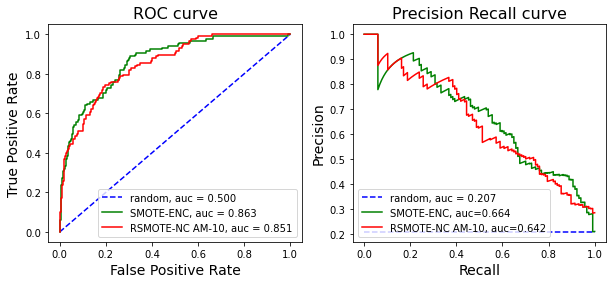

In [40]:
##Create ROC-AUC and PR-AUC curve

dict_models = {"SMOTE-ENC": MODELS / 'rain_mysmotenc.sav',
                "RSMOTE-NC AM-10": MODELS / 'rain_rsmotenc_ahmadL110.sav'}

#generate_curves(dict_models, X_test, y_test,save = REPORTS / "rain_roc_prc.jpeg")
generate_curves(dict_models, X_test, y_test)

<Figure size 720x720 with 0 Axes>

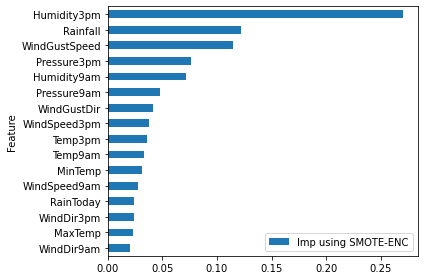

In [34]:
## Find out top 5 most important features using our new SMOTE method

filename = (MODELS / 'rain_mysmotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=X_train.columns).nlargest(20))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using SMOTE-ENC']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'rain_mysmotenc.jpeg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

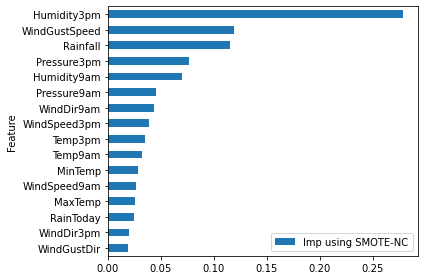

In [35]:
## Find out top 5 most important features using the existing SMOTE method

filename = (MODELS / 'rain_smotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=X_train.columns).nlargest(20))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using SMOTE-NC']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'rain_smotenc.jpeg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

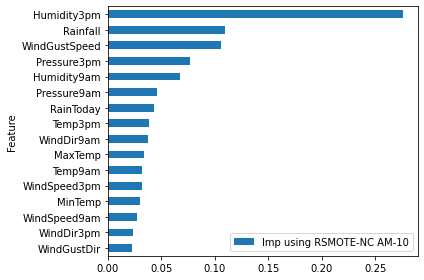

In [36]:
filename = (MODELS / 'rain_rsmotenc_ahmadMah10.sav')
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=X_train.columns).nlargest(20))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using RSMOTE-NC AM-10']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'rain_rsmotenc_ahmadMah10.jpeg', bbox_inches='tight')

In [38]:
filename = (MODELS / 'rain_mysmotenc.sav')
model1 = pickle.load(open(filename, 'rb'))

filename = (MODELS / 'rain_smotenc.sav')
model2 = pickle.load(open(filename, 'rb'))

for scoring in ('precision', 'precision_micro', 'precision_macro', 'precision_weighted',
                'f1', 'f1_micro', 'f1_macro', 'f1_weighted', 
                'recall', 'recall_macro', 'recall_micro', 'recall_weighted'):
    
    cv_scoremodel1 = cross_val_score(model1, X_train, y_train, cv=kfold, scoring = scoring)
    cv_scoremodel2 = cross_val_score(model2, X_train, y_train, cv=kfold, scoring = scoring)
    t, p = stats.ttest_ind(cv_scoremodel1, cv_scoremodel2, equal_var = True)
    print(scoring, t, p)

precision -0.32737668531581154 0.7517853352887067
precision_micro -0.41345217839418985 0.6901361047994707
precision_macro -0.49661462177603083 0.6328178495507297
precision_weighted -0.8310635178596517 0.4300416563529904
f1 -0.7639598749176042 0.46682282177744006
f1_micro -0.4134521783941909 0.6901361047994701
f1_macro -0.6182336502477979 0.5536106670310739
f1_weighted -0.4884362037433444 0.6383474257599001
recall -1.6420712477460015 0.13920141606832223
recall_macro -1.1243504379784037 0.29346621863372085
recall_micro -0.41345217839418985 0.6901361047994707
recall_weighted -0.41345217839418985 0.6901361047994707


In [33]:
idnum = [0,1,2,4,7,8,9,10,11,12,13,14,15]
idbin = []
idcat = [3,5,6]

data = encoded_df.to_numpy()

distance_matrices = {"Euclidean": cdist(data.astype(np.float16),data.astype(np.float16)),
                    "Gower" : distmix(data, method = "gower", weigths_boolean = False, nbins=0, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Huang" : distmix(data, method = "huang", weigths_boolean = False, nbins=0, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad - 3": distmix(data, method = "ahmad", weigths_boolean = True, nbins=3, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad - 10": distmix(data, method = "ahmad", weigths_boolean = True, nbins=10, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad Mah - 3" : distmix(data, method = "ahmad_mahalanobis", weigths_boolean = True, nbins=3, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad Mah - 10" : distmix(data, method = "ahmad_mahalanobis", weigths_boolean = True, nbins=10, idnum = idnum, idbin = idbin, idcat = idcat )}

[0, 1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[]
[3, 5, 6]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
[0, 1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[]
[3, 5, 6]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
[0, 1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[]
[3, 5, 6]
---------------------------
Weigths calculated
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Calculating coocccur...
Same DataFrame
Cooccur time:  4.026310920715332
Cat finished
---------------------------
[0, 1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[]
[3, 5, 6]
---------------------------
Weigths calculated
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Calculating coocccur...

In [ ]:
np.sum(df_target)

0
RangeIndex(start=0, stop=2258, step=1)
Int64Index([ 96119, 141794,  32568,  54375,  72691, 105379,  61406,   7376,
             43864,  33039,
            ...
            100445,  83418,  78764,  95941,  93036,  48229,  55540,  28647,
            130656,  98172],
           dtype='int64', length=2258)
0
RangeIndex(start=0, stop=2258, step=1)
Int64Index([ 96119, 141794,  32568,  54375,  72691, 105379,  61406,   7376,
             43864,  33039,
            ...
            100445,  83418,  78764,  95941,  93036,  48229,  55540,  28647,
            130656,  98172],
           dtype='int64', length=2258)
0
RangeIndex(start=0, stop=2258, step=1)
Int64Index([ 96119, 141794,  32568,  54375,  72691, 105379,  61406,   7376,
             43864,  33039,
            ...
            100445,  83418,  78764,  95941,  93036,  48229,  55540,  28647,
            130656,  98172],
           dtype='int64', length=2258)
0
RangeIndex(start=0, stop=2258, step=1)
Int64Index([ 96119, 141794,  32568,  54375, 

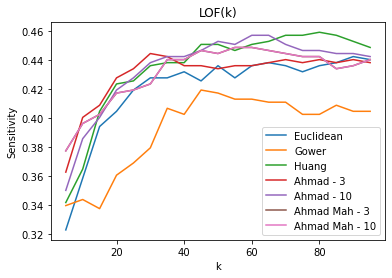

0
RangeIndex(start=0, stop=2258, step=1)
Int64Index([ 96119, 141794,  32568,  54375,  72691, 105379,  61406,   7376,
             43864,  33039,
            ...
            100445,  83418,  78764,  95941,  93036,  48229,  55540,  28647,
            130656,  98172],
           dtype='int64', length=2258)
0
RangeIndex(start=0, stop=2258, step=1)
Int64Index([ 96119, 141794,  32568,  54375,  72691, 105379,  61406,   7376,
             43864,  33039,
            ...
            100445,  83418,  78764,  95941,  93036,  48229,  55540,  28647,
            130656,  98172],
           dtype='int64', length=2258)
0
RangeIndex(start=0, stop=2258, step=1)
Int64Index([ 96119, 141794,  32568,  54375,  72691, 105379,  61406,   7376,
             43864,  33039,
            ...
            100445,  83418,  78764,  95941,  93036,  48229,  55540,  28647,
            130656,  98172],
           dtype='int64', length=2258)
0
RangeIndex(start=0, stop=2258, step=1)
Int64Index([ 96119, 141794,  32568,  54375, 

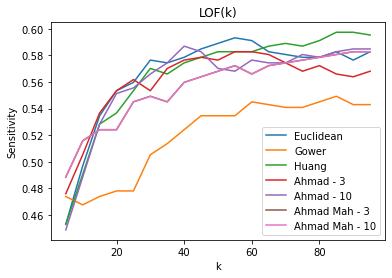

0
RangeIndex(start=0, stop=2258, step=1)
Int64Index([ 96119, 141794,  32568,  54375,  72691, 105379,  61406,   7376,
             43864,  33039,
            ...
            100445,  83418,  78764,  95941,  93036,  48229,  55540,  28647,
            130656,  98172],
           dtype='int64', length=2258)
0
RangeIndex(start=0, stop=2258, step=1)
Int64Index([ 96119, 141794,  32568,  54375,  72691, 105379,  61406,   7376,
             43864,  33039,
            ...
            100445,  83418,  78764,  95941,  93036,  48229,  55540,  28647,
            130656,  98172],
           dtype='int64', length=2258)
0
RangeIndex(start=0, stop=2258, step=1)
Int64Index([ 96119, 141794,  32568,  54375,  72691, 105379,  61406,   7376,
             43864,  33039,
            ...
            100445,  83418,  78764,  95941,  93036,  48229,  55540,  28647,
            130656,  98172],
           dtype='int64', length=2258)
0
RangeIndex(start=0, stop=2258, step=1)
Int64Index([ 96119, 141794,  32568,  54375, 

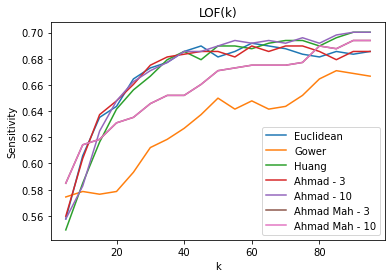

In [34]:
outlier_prevelance = 477
index = encoded_df.index
neigbs = list(range(5,100,5))
metric = "Sensitivity"

test_distances(distance_matrices, df_target, index, neigbs, outlier_prevelance, metric, save = REPORTS / "rain_distances100.jpeg")
test_distances(distance_matrices, df_target, index, neigbs, int(outlier_prevelance*1.5), metric, save = REPORTS / "rain_distances150.jpeg")
test_distances(distance_matrices, df_target, index, neigbs, outlier_prevelance*2, metric, save = REPORTS / "rain_distances200.jpeg")